# Time Series Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [8]:
df = pd.read_csv('processed_df.csv')
df.timedelta = pd.to_timedelta(df.timedelta)

# Let's drop the std columns
cols_to_drop=['by_gse_std','bz_gse_std','bt_std','density_std','speed_std']
df.drop(cols_to_drop, axis=1, inplace=True)
print ('shape:',df.shape)
df.head(2)

shape: (139872, 16)


,timedelta,period,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace
0,00:00:00,train_a,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000
1,01:00:00,train_a,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333


In [9]:
dfa = df[df.period=='train_a'][:10000]
dfa.drop(['period'], axis=1, inplace=True)
print (dfa.shape)
dfa.head(2)

(10000, 15)


,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace
0,00:00:00,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000
1,01:00:00,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333


### Train Test Split

In [11]:
nobs = 4
dfa_train, dfa_test = dfa[:-nobs], dfa[-nobs:]

print('train shape:', dfa_train.shape, 'test shape:', dfa_test.shape)

train shape: (9996, 15) test shape: (4, 15)


# Vector Auto Regression (VAR)
- https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/


### Testing Causation using Granger’s Causality Test

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In [12]:
#from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [13]:
dfa_train.head(2)

,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace
0,00:00:00,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000
1,01:00:00,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333


In [14]:
from statsmodels.tsa.stattools import grangercausalitytests
df = dfa_train.drop(['timedelta'], axis=1)

In [15]:
def grangers_causation_matrix(df, variables, test='ssr_chi2test', maxlag=12, verbose=False):
    dfc = pd.DataFrame(np.zeros((len(variables), len(variables))),
                       columns=variables, index=variables)
    for r in variables:
        for c in variables:
            test_res = grangercausalitytests(df[[r, c]], maxlag=12, verbose=False)
            min_p_val= np.min([ round(test_res[i+1][0][test][1], 4) for i in range(12)])
            dfc.loc[r, c] = min_p_val
    dfc.columns = [var + '_x' for var in variables]
    dfc.index = [var + '_y' for var in variables]
    return dfc

In [16]:
dfc = grangers_causation_matrix(df, variables = df.columns)
dfc

,bx_gse_x,by_gse_x,bz_gse_x,theta_gse_x,phi_gse_x,bt_x,density_x,speed_x,temperature_x,dst_x,smoothed_ssn_x,gse_x_ace_x,gse_y_ace_x,gse_z_ace_x
bx_gse_y,1.0000,0.0000,0.0146,0.0006,0.0000,0.1381,0.0518,0.0217,0.0011,0.0132,0.0071,0.0507,0.0199,0.0118
by_gse_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0041,0.0001,0.0000,0.0000,0.8277,0.0077,0.0260,0.0050
bz_gse_y,0.0034,0.0000,1.0000,0.0000,0.0021,0.0650,0.0002,0.0000,0.0017,0.0361,0.0062,0.1131,0.3358,0.0545
theta_gse_y,0.0015,0.0000,0.0000,1.0000,0.0001,0.2195,0.0261,0.0192,0.1739,0.2432,0.0109,0.1068,0.4769,0.1802
phi_gse_y,0.0000,0.0000,0.0234,0.0004,1.0000,0.0007,0.0005,0.0002,0.0044,0.1027,0.2848,0.0002,0.0075,0.0004
bt_y,0.0026,0.0000,0.0003,0.0034,0.0299,1.0000,0.0000,0.0000,0.0002,0.0001,0.4736,0.6901,0.2644,0.8954
density_y,0.1836,0.0011,0.0111,0.0457,0.0388,0.0000,1.0000,0.0000,0.0000,0.0002,0.0001,0.0000,0.0000,0.0000
speed_y,0.0000,0.0002,0.0001,0.0058,0.0002,0.0000,0.0000,1.0000,0.0000,0.0114,0.3428,0.1730,0.3947,0.6046
temperature_y,0.0051,0.0000,0.0000,0.0552,0.0416,0.0000,0.0008,0.0000,1.0000,0.0415,0.5220,0.0374,0.0229,0.0385
dst_y,0.0000,0.0000,0.0000,0.0000,0.0362,0.0000,0.0000,0.0000,0.0000,1.0000,0.3766,0.0285,0.0191,0.0252


So how to read the above output?

Check the other notebook `04_time_series_basics.ipynb` for it's explanation.

## Differencing plot

In [17]:
dfa_train.head(2)

,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace
0,00:00:00,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000
1,01:00:00,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333


In [18]:
dfa_train.timedelta[1] - dfa_train.timedelta[0] 

Timedelta('0 days 01:00:00')

In [19]:
dfa_train.diff().index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9986, 9987, 9988, 9989, 9990, 9991, 9992, 9993, 9994, 9995],
           dtype='int64', length=9996)

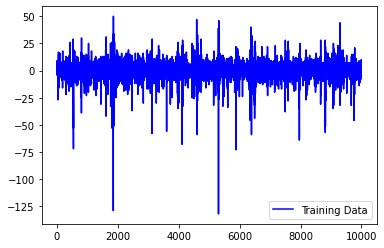

In [20]:
feature = 'dst'
plt.plot(dfa_train.diff(2).index, dfa_train.diff(2)[feature],
             'b', label = "Training Data" )
plt.legend()

## Cointegration Test

**Order of integration(d)** is the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.

In [32]:
dfa_train = dfa_train.drop(['timedelta'], axis=1)
dfa_train.head(2)

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace
0,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,68880.341667,-7,65.400000,1.522377e+06,143704.600000,149496.700000
1,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,52203.225000,-10,65.421154,1.522503e+06,143388.108333,149560.758333


In [34]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
res = coint_johansen(dfa_train, -1, 5)
res.lr1

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:569: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


array([5.03891461e+03, 4.28146427e+03, 3.60698149e+03, 2.97742784e+03,
       2.38141220e+03, 1.82186595e+03, 1.30199452e+03, 9.04018477e+02,
       6.64019079e+02, 4.33208177e+02, 2.68325256e+02, 1.28286278e+02,
       3.65357567e+01, 4.02473611e-01])

In [26]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', round(trace,2), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


df=dfa_train.drop('timedelta', axis=1)
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
bx_gse ::  5038.91   > nan       =>   False
by_gse ::  4281.46   > nan       =>   False
bz_gse ::  3606.98   > 311.1288  =>   True
theta_gse ::  2977.43   > 263.2603  =>   True
phi_gse ::  2381.41   > 219.4051  =>   True
bt     ::  1821.87   > 179.5199  =>   True
density ::  1301.99   > 143.6691  =>   True
speed  ::  904.02    > 111.7797  =>   True
temperature ::  664.02    > 83.9383   =>   True
dst    ::  433.21    > 60.0627   =>   True
smoothed_ssn ::  268.33    > 40.1749   =>   True
gse_x_ace ::  128.29    > 24.2761   =>   True
gse_y_ace ::  36.54     > 12.3212   =>   True
gse_z_ace ::  0.4       > 4.1296    =>   False


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:569: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


## Check for Stationarity and Make the Time Series Stationary

- Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

In [27]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        

In [28]:
# ADF Test on each column
for name, column in dfa_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

/usr/local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


    Augmented Dickey-Fuller Test on "timedelta" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -63.3281
 No. Lags Chosen       = 11
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "bx_gse" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.4233
 No. Lags Chosen       = 10
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "by_gse" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Lev

We see some of the series are not stationary. So let's do differenced calculation.

In [30]:
dfa_diff1 = dfa_train.diff().dropna()
dfa_diff1.head(2)

,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace
1,01:00:00,-0.544333,-0.879000,0.4205,3.079667,8.847500,0.144833,-0.358250,-25.197667,-16677.116667,-3.0,0.021154,126.416667,-316.491667,64.058333
2,01:00:00,-0.528333,0.014667,0.9350,6.053333,0.123167,0.588000,0.110417,-1.031583,-3507.933333,0.0,0.021154,126.416667,-316.491667,64.058333


In [31]:
# ADF Test on each column
for name, column in dfa_diff1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

/usr/local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


    Augmented Dickey-Fuller Test on "timedelta" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = nan
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "bx_gse" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.0999
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "by_gse" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

In [35]:
dfa_diff2 = dfa_train.diff().diff().dropna()
dfa_diff2.head(2)

for name, column in dfa_diff2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "bx_gse" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -31.3471
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "by_gse" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -31.5222
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "bz_gse" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

### How to Select the Order (P) of VAR model

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

In [36]:
dfa_diff2.head(2)

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,temperature,dst,smoothed_ssn,gse_x_ace,gse_y_ace,gse_z_ace
2,0.016000,0.893667,0.514500,2.973667,-8.724333,0.443167,0.468667,24.166083,13169.183333,3.0,0.000000e+00,-6.984919e-10,-5.820766e-11,2.910383e-11
3,0.881667,-2.068500,-1.364833,-9.120667,15.901000,-0.712500,1.700500,19.835333,31840.258333,4.0,-1.421085e-14,4.656613e-10,2.910383e-11,-2.910383e-11


In [42]:
model = VAR(dfa_diff2)
AIC_min = np.inf
AIC_min_i = np.inf

#for i in [1,2,3,4,5,6,7,8,9, 12, 15, 18, 20]:
for i in range(45, 55, 1):
    result = model.fit(i)
    if result.aic < AIC_min:
        AIC_min = result.aic
        AIC_min_i = i
        
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

print ( AIC_min, AIC_min_i)


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Lag Order = 45
AIC :  33.740342315678824
BIC :  40.138068536178814
FPE :  451108601564968.1
HQIC:  35.906481931473806 

Lag Order = 46
AIC :  33.746052937116275
BIC :  40.286291683442904
FPE :  453766254384943.6
HQIC:  35.960455456202006 

Lag Order = 47
AIC :  33.669703986002915
BIC :  40.35247994186983
FPE :  420483013527675.94
HQIC:  35.93237824946866 

Lag Order = 48
AIC :  33.150506403994434
BIC :  39.975844259961264
FPE :  250231089042053.47
HQIC:  35.461461255451795 

Lag Order = 49
AIC :  33.15563742124769
BIC :  40.12356187472267
FPE :  251565123866777.0
HQIC:  35.51488170683159 

Lag Order = 50
AIC :  33.1658083070692
BIC :  40.276344062311765
FPE :  254186098999677.44
HQIC:  35.573350875438834 

Lag Order = 51
AIC :  33.17476136918436
BIC :  40.42793313730772
FPE :  256523850649724.06
HQIC:  35.6306110715242 

Lag Order = 52
AIC :  33.18166190354002
BIC :  40.577494402513764
FPE :  258354399074282.66
HQIC:  35.68582759356077 

Lag Order = 53
AIC :  33.19417267902346
BIC :  4

So the minimum is found at lag=48

In [43]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,43.26,43.27,6.145e+18,43.27
1,40.99,41.14,6.326e+17,41.04
2,39.57,39.86,1.527e+17,39.67
3,38.74,39.17,6.646e+16,38.88
4,38.18,38.76,3.810e+16,38.37
5,37.84,38.56,2.721e+16,38.09
6,37.53,38.40,1.998e+16,37.83
7,37.31,38.32,1.604e+16,37.65
8,37.15,38.29,1.359e+16,37.54
9,37.01,38.30,1.187e+16,37.45


And they agree.

In [44]:
model_fitted = model.fit(48)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Jan, 2021
Time:                     10:36:41
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                    39.9758
Nobs:                     9946.00    HQIC:                   35.4615
Log likelihood:          -353014.    FPE:                2.50231e+14
AIC:                      33.1505    Det(Omega_mle):     1.00057e+14
--------------------------------------------------------------------
Results for equation bx_gse
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000391         0.018346            0.021           0.983
L1.bx_gse               -1.097747         0.010940         -100.344           0.000
L1.by_gse               -0.070662         0.010

## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

**So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.**

A common way of checking for serial correlation of errors can be measured using the **Durbin Watson’s Statistic**.

**Note:**
The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.


In [125]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

bx_gse : 2.01
by_gse : 2.0
bz_gse : 1.99
theta_gse : 2.0
phi_gse : 2.0
bt : 2.0
density : 2.0
speed : 1.99
dst : 2.01


The serial correlation seems quite alright. Let’s proceed with the forecast.

## How to Forecast VAR model using statsmodels

In [ ]:
lag_order = model_fitted.k_ar

print ('lag order:', lag_order)

In [126]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df.values[-lag_order:]
forecast_input

6


array([[-6.25138889e+00, -9.75357143e-01,  8.79261905e-01,
         7.65913946e+00,  1.88259168e+02,  6.80634807e+00,
         2.35320246e+00,  5.45692930e+02, -2.10000000e+01],
       [-5.45183333e+00, -1.90550000e+00,  7.36583333e-01,
         7.07875000e+00,  1.98510167e+02,  6.22525000e+00,
         2.02983333e+00,  5.41367250e+02, -2.00000000e+01],
       [-6.11616667e+00, -1.87500000e-01,  2.56500000e-01,
         2.41700000e+00,  1.81710167e+02,  6.23866667e+00,
         1.75008333e+00,  5.30311833e+02, -2.00000000e+01],
       [-5.17050000e+00,  2.23950000e+00, -3.31000000e-01,
        -3.31233333e+00,  1.56403667e+02,  5.81566667e+00,
         1.47466667e+00,  5.29517667e+02, -2.10000000e+01],
       [-3.07633333e+00,  3.11033333e+00,  2.92333333e-01,
         3.28283333e+00,  1.32357000e+02,  5.15083333e+00,
         1.27566667e+00,  5.48122250e+02, -1.80000000e+01],
       [-5.74316667e+00,  5.23166667e-01,  6.57000000e-01,
         6.37483333e+00,  1.74592333e+02,  5.926833

In [130]:
# Forecast
nobs = 4
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_result = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_fc')
df_result

,bx_gse_fc,by_gse_fc,bz_gse_fc,theta_gse_fc,phi_gse_fc,bt_fc,density_fc,speed_fc,dst_fc
2496,-5.065448,0.893768,0.630777,5.859570,170.748571,5.710351,1.634659,515.286570,-20.246529
2497,-4.844968,0.599691,0.025323,1.957556,176.573576,5.828322,2.195062,514.467418,-19.093599
2498,-3.935459,0.859245,-0.477170,-1.833353,171.679058,5.806709,2.123169,512.604182,-18.811558
2499,-3.711402,0.821629,-0.462859,-1.474469,178.549954,5.711207,2.057775,510.282285,-20.536969


Note if you had used the differenced data then you need to de-difference it as many times you had differenced the original input data.

## Plot forecast vs Actual

In [131]:
df.head(2)

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,dst
0,-6.149500,1.6455,0.844667,7.103667,165.420333,7.140000,1.174167,355.278250,-7
1,-6.693833,0.7665,1.265167,10.183333,174.267833,7.284833,0.815917,330.080583,-10


In [132]:
df.tail(2)

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bt,density,speed,dst
2498,-3.076333,3.110333,0.292333,3.282833,132.357000,5.150833,1.275667,548.122250,-18
2499,-5.743167,0.523167,0.657000,6.374833,174.592333,5.926833,1.474333,519.631667,-18


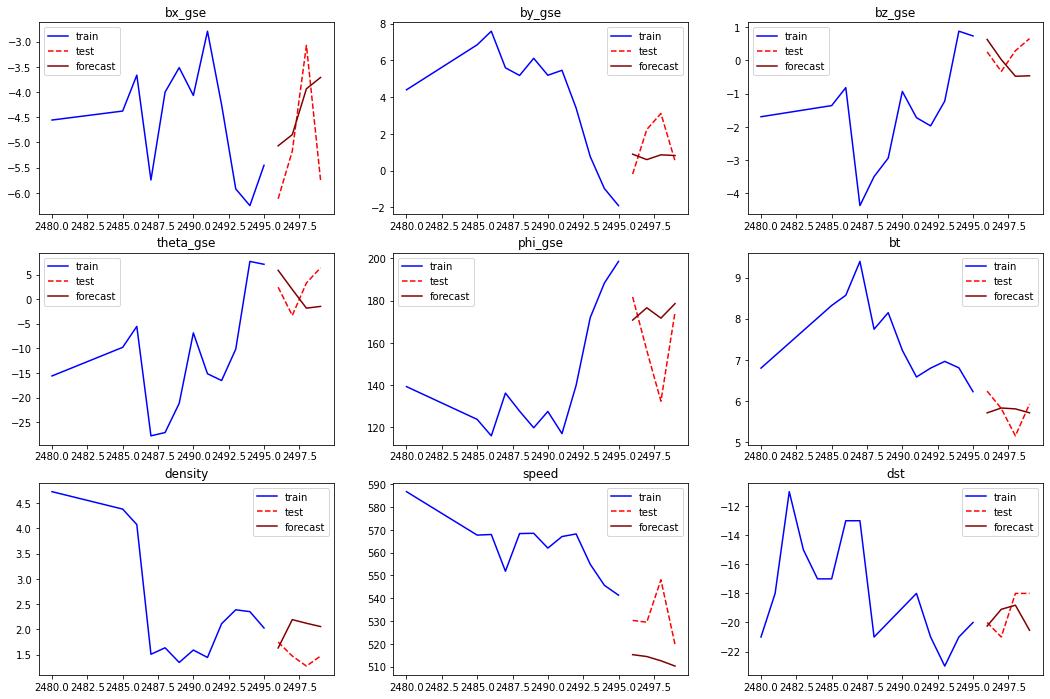

In [143]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(df.columns):
    plt.subplot(3,3,1+i)
    plt.plot(df.index[-20:-nobs], df[col][-20:-nobs], '-b', label='train')
    plt.plot(df.index[-nobs:], df[col][-nobs:], '--r', label='test')
    
    plt.plot(df_result.index, df_result[col+'_fc'], color='maroon', label='forecast')
    plt.legend()
    plt.title(col)

    

## Evaluate the Forecasts

In [144]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [148]:

for i, col in enumerate(df.columns):
    print('\nForecast Accuracy of: ', col)    
    accuracy_prod = forecast_accuracy(df_result[col+'_fc'].values, df[col][-4:])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))


Forecast Accuracy of:  bx_gse
mape :  0.2169
me :  0.6372
mae :  1.0668
mpe :  -0.0773
rmse :  1.2325
corr :  0.4432
minmax :  -0.2753

Forecast Accuracy of:  by_gse
mape :  1.9483
me :  -0.6278
mae :  1.3177
mpe :  -1.6631
rmse :  1.5012
corr :  -0.3876
minmax :  0.7573

Forecast Accuracy of:  bz_gse
mape :  1.7181
me :  -0.2897
mae :  0.655
mpe :  -0.9885
rmse :  0.7269
corr :  -0.3557
minmax :  4.7503

Forecast Accuracy of:  theta_gse
mape :  1.4513
me :  -1.0633
mae :  5.4195
mpe :  -0.7391
rmse :  5.6438
corr :  -0.4049
minmax :  1.5173

Forecast Accuracy of:  phi_gse
mape :  0.1273
me :  13.122
mae :  18.6028
mpe :  0.0971
rmse :  22.8521
corr :  0.1956
minmax :  0.1064

Forecast Accuracy of:  bt
mape :  0.0626
me :  -0.0189
mae :  0.3531
mpe :  0.0021
rmse :  0.4347
corr :  -0.6658
minmax :  0.059

Forecast Accuracy of:  density
mape :  0.4036
me :  0.509
mae :  0.5667
mpe :  0.3707
rmse :  0.6307
corr :  -0.8517
minmax :  0.2692

Forecast Accuracy of:  speed
mape :  0.0349
me 

In [106]:
df = pd.read_csv('test_data.csv')
df = df[:10].drop(['ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'], axis=1)
df

,date,rgnp,pgnp
0,1959-01-01,1606.4,1608.3
1,1959-04-01,1637.0,1622.2
2,1959-07-01,1629.5,1636.2
3,1959-10-01,1643.4,1650.3
4,1960-01-01,1671.6,1664.6
5,1960-04-01,1666.8,1679.0
6,1960-07-01,1668.4,1693.5
7,1960-10-01,1654.1,1708.2
8,1961-01-01,1671.3,1722.9
9,1961-04-01,1692.1,1737.8
